<a href="https://colab.research.google.com/github/julianovale/PO450/blob/main/ProjetoPO450_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações - Parâmetros - GPU

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

args = {
    'batch_size': 20,
    'num_workers': 2,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 60
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Importando o Dataset

In [2]:
url = 'https://raw.githubusercontent.com/julianovale/PO450/main/seade/dados.csv'

df = pd.read_csv(url, delimiter = ';', decimal=',', encoding= 'Windows-1252')

# Separando Treinamento e Teste

In [3]:
# torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test = df.iloc[indices[train_size:]]

print(len(df_train), len(df_test))
display(df_train.head())

df_train.to_csv('covid_train.csv', index=False)
df_test.to_csv('covid_test.csv', index=False)

! ls

516 129


,CodIBGE,Localidade,Populacao,Pop60mais%,DensDem,RazaoSexos,GrauUrb,TxMortalidade,PIBPerCapita,VlAdTPop,VlAdAPPop,VlAdIndPop,VlAdSrvPop,VlAdAgrPop,ImpostosPop,ConsEElTPop,ConsEEIndPop,ConsEECSPop,ConsEERurPop,ConsEEResPop,ConsEEIlPubPop,FrotaVeículosPop,AutomóveisPop,LeitosMilHab,LeitosSUSMilHab,AuxEnfMilHab,EnfMilHab,MedMilHab,TecEnfMilHab,EmpFormPop,RazaoEmpSexo,RendMedEmpregos,IDH-M,IDH-Long,IDH-Educ,IDH-Renda,RendaPCapita,DomMeioSMPC%,DomQuarSMPC%,Agua%,Lixo%,Esgoto%,CasosCovid,ObitosCovid,IncidCovid%,LetalidCovid%,MortalidCovid%
227,3519709,Ibiúna,76867,14.227172,0.722346,101.47,37.09,7.31,22574.94,20.413258,3.864276,3.614141,13.339535,3.459582,1.727900,2.990776,0.317431,0.258485,1.067493,0.487778,0.859589,0.679420,0.381841,2.27,0.83,2.81,0.97,0.45,2.85,0.184448,1.162929,2205.95,0.710,0.832,0.614,0.700,504.51,30.31,10.19,90.33,98.57,54.54,3863,112,5.054298,2.899301,0.146539
643,3557105,Votuporanga,92193,18.659768,21.811267,94.82,97.20,7.59,32385.52,28.988452,3.760738,5.489286,23.014159,0.485007,2.778467,2.643151,0.318180,0.693654,0.341837,1.000390,0.289089,0.969759,0.465198,2.25,1.26,2.74,3.33,3.28,4.69,0.313733,1.331453,2244.17,0.790,0.857,0.744,0.772,808.00,12.51,3.95,99.50,99.79,98.95,11872,341,12.938099,2.872305,0.371622
514,3545704,Santa Albertina,5657,23.051087,0.208002,100.46,89.43,10.21,32196.95,30.148777,5.257918,9.239903,16.412397,4.496479,2.207534,2.187202,0.027223,0.495316,0.371575,0.987626,0.305462,0.783808,0.411349,0.00,0.00,0.18,2.82,0.70,6.87,0.350893,3.760192,2646.12,0.728,0.809,0.665,0.716,624.47,16.95,3.64,99.53,99.77,97.90,555,19,9.784908,3.423423,0.334979
257,3522307,Itapetininga,161509,14.302609,0.895018,99.06,92.14,6.72,30286.41,26.342698,3.638111,6.479236,18.343113,1.520349,3.093113,3.226285,1.802544,0.294120,0.166975,0.740083,0.222563,0.655753,0.351819,0.90,0.63,2.25,1.74,1.55,5.78,0.225065,1.403783,2171.76,0.763,0.864,0.705,0.728,629.40,21.92,6.61,98.78,99.71,95.22,13918,155,8.690603,1.113666,0.096784
378,3533403,Nova Odessa,58490,14.964951,7.865429,97.70,98.37,6.29,62369.32,51.197527,4.226202,17.045392,33.938369,0.213766,9.334511,6.733219,4.861805,0.588955,0.020414,0.987382,0.274662,0.772542,0.481330,0.92,0.92,3.35,1.32,0.56,4.11,0.334416,1.707641,3039.47,0.791,0.861,0.762,0.755,733.41,10.48,3.67,98.57,99.87,96.88,5107,148,8.799256,2.897983,0.255001


covid_test.csv	covid_train.csv  sample_data


# Construindo classe dataset

In [4]:

class Covid(Dataset):
  def __init__(self, csv_path):
    self.dados = pd.read_csv(csv_path).to_numpy()

  def __getitem__(self, idx):
    sample = self.dados[idx][3:-5]
    label = self.dados[idx][-2:-1] 

    # converte para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label = torch.from_numpy(label.astype(np.float32))

    return sample, label

  def __len__(self):
    return len(self.dados)

In [5]:
train_set = Covid('covid_train.csv')
test_set = Covid('covid_test.csv')

dado, rotulo = train_set[0]
print(rotulo)
print(dado)

tensor([2.8993])
tensor([1.4227e+01, 7.2235e-01, 1.0147e+02, 3.7090e+01, 7.3100e+00, 2.2575e+04,
        2.0413e+01, 3.8643e+00, 3.6141e+00, 1.3340e+01, 3.4596e+00, 1.7279e+00,
        2.9908e+00, 3.1743e-01, 2.5849e-01, 1.0675e+00, 4.8778e-01, 8.5959e-01,
        6.7942e-01, 3.8184e-01, 2.2700e+00, 8.3000e-01, 2.8100e+00, 9.7000e-01,
        4.5000e-01, 2.8500e+00, 1.8445e-01, 1.1629e+00, 2.2059e+03, 7.1000e-01,
        8.3200e-01, 6.1400e-01, 7.0000e-01, 5.0451e+02, 3.0310e+01, 1.0190e+01,
        9.0330e+01, 9.8570e+01, 5.4540e+01])


# Dataloader

In [6]:
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers']
                          ) 

test_loader = DataLoader(test_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers']
                          )

In [7]:
for batch in train_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  break

torch.Size([20, 39]) torch.Size([20, 1])


# Implementando MLP

In [8]:
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)

  def forward(self, X):

    feature = self.features(X)
    output  = self.out(feature)

    return output

input_size  = len(train_set[0][0])
hidden_size = 128
out_size    = 1 # para regressão é "um" 

net = MLP(input_size, hidden_size, out_size).to(args['device']) #cast na GPU

In [9]:
net

MLP(
  (features): Sequential(
    (0): Linear(in_features=39, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)

# Definindo função-objetivo (Loss) e otimizador

In [10]:
criterion = nn.L1Loss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Fluxo de treinamento e validação

In [11]:
def train(train_loader, net, epoch):

  net.train()

  epoch_loss = []

  for batch in train_loader:
    
    dado, rotulo = batch

    # Cast na GPU
    dado = dado.to(args['device']) 
    rotulo = rotulo.to(args['device']) 

    # Foward
    pred = net(dado)
    loss = criterion(pred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  print("*************** TREINAMENTO ***************")
  print("Época: %d, Função de perda: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))

  return epoch_loss.mean()

In [12]:
def test(test_loader, net, epoch):

  net.eval()
  with torch.no_grad():

    epoch_loss = []
    
    for batch in test_loader:
      
      dado, rotulo = batch

      # Cast na GPU
      dado = dado.to(args['device']) 
      rotulo = rotulo.to(args['device']) 

      # Foward
      pred = net(dado)
      loss = criterion(pred, rotulo)
      epoch_loss.append(loss.cpu().data)

    epoch_loss = np.asarray(epoch_loss)
    
    print("*************** VALIDAÇÃO ***************")
    print("Época: %d, Função de perda: %.4f +\- %.4f" % (epoch, epoch_loss.mean(), epoch_loss.std()))

  return epoch_loss.mean()

In [13]:
train_losses, test_losses = [], []

for epoch in range(args['num_epochs']):
  train_losses.append(train(train_loader, net, epoch))
  test_losses.append(test(test_loader, net, epoch))

*************** TREINAMENTO ***************
Época: 0, Função de perda: 476.2785 +\- 275.4799
*************** VALIDAÇÃO ***************
Época: 0, Função de perda: 985.6123 +\- 211.5506
*************** TREINAMENTO ***************
Época: 1, Função de perda: 664.0908 +\- 375.6882
*************** VALIDAÇÃO ***************
Época: 1, Função de perda: 250.1176 +\- 50.9224
*************** TREINAMENTO ***************
Época: 2, Função de perda: 1113.5979 +\- 472.2031
*************** VALIDAÇÃO ***************
Época: 2, Função de perda: 1748.2069 +\- 379.4308
*************** TREINAMENTO ***************
Época: 3, Função de perda: 1502.6941 +\- 270.2719
*************** VALIDAÇÃO ***************
Época: 3, Função de perda: 1053.9746 +\- 280.1407
*************** TREINAMENTO ***************
Época: 4, Função de perda: 445.3295 +\- 264.0272
*************** VALIDAÇÃO ***************
Época: 4, Função de perda: 830.1431 +\- 276.2753
*************** TREINAMENTO ***************
Época: 5, Função de perda: 1271.4

In [14]:
'''
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)
'''

"\nXtest = torch.stack([tup[0] for tup in test_set])\nXtest = Xtest.to(args['device'])\n\nytest = torch.stack([tup[1] for tup in test_set])\nypred = net(Xtest).cpu().data\n\ndata = torch.cat((ytest, ypred), axis=1)\n\ndf_results = pd.DataFrame(data, columns=['ypred', 'ytest'])\ndf_results.head(20)\n"

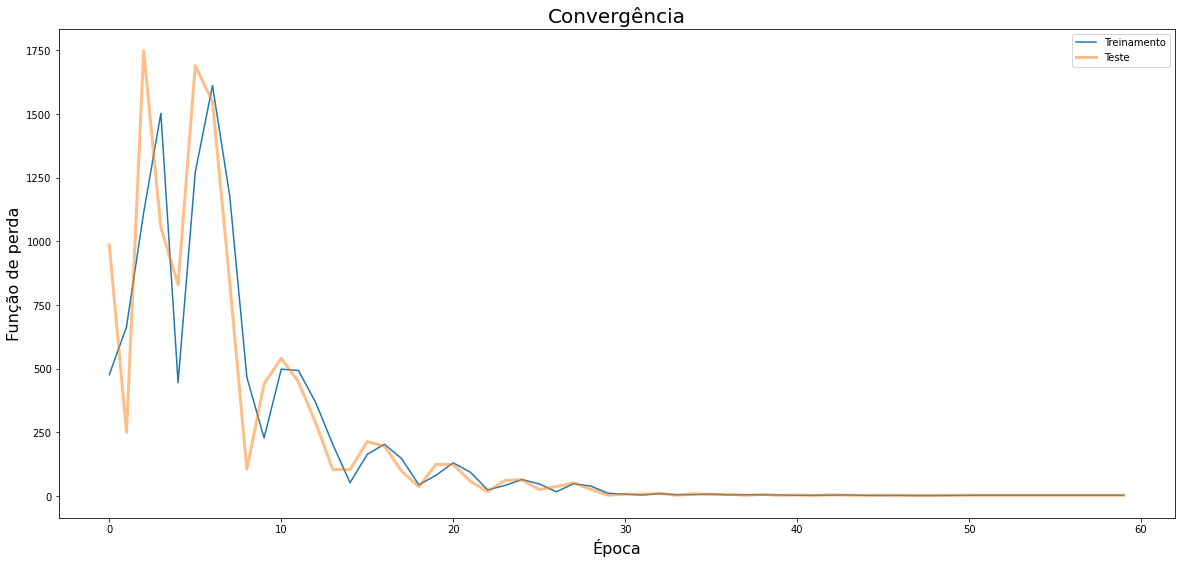

In [15]:
plt.figure(figsize=(20,9))
plt.plot(train_losses, label="Treinamento")
plt.plot(test_losses, label="Teste", linewidth=3, alpha=0.5)
plt.xlabel("Época", fontsize=16)
plt.ylabel("Função de perda", fontsize=16)
plt.title("Convergência", fontsize=20)
plt.legend()
plt.show()